# preparing the dataset

In [123]:
import random
from torch.utils.data import Dataset


class SiameseNetworkDataset(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform

        # Build a label-to-indices mapping for faster class-based sampling:
        # Dict: {0: [1, 2, 40,...],
        #        1: [13, 7, 5,...],
        #        ...}
        self.label_to_indices = {}
        for idx, (_, label) in enumerate(mnist_dataset):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)
        # print out 10 examples of each class
        # for label, indices in self.label_to_indices.items():
        #     print(f"Label {label}: {indices[:10]}")
        # print("\n")

    def __getitem__(self, index):
        # get the data tuple at given index
        img0, label0 = self.mnist_dataset[index]

        # bool making sure training distribution is about 50/50
        # -> 50% of pairs are of the same class, the other 50% are of different classes
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            # get a different image of the same class
            same_class_indices = self.label_to_indices[label0]
            filtered_indices = [i for i in same_class_indices if i != index]
            img1_index = random.choice(filtered_indices)
        else:
            # get a label different than label0
            different_labels = [label for label in self.label_to_indices.keys() if label != label0]
            different_label = random.choice(different_labels)
            # get a random index from the selected different class
            img1_index = random.choice(self.label_to_indices[different_label])

        # get the img tuple
        img1, label1 = self.mnist_dataset[img1_index]

        # Convert to grayscale (MNIST is already grayscale, but this ensures PIL.Image format)
        # TODO: try without these
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # 0 = same label/class, 1 = different labels/classes
        pair_label = torch.tensor([int(label0 != label1)], dtype=torch.float32)
        return img0, img1, pair_label

    def __len__(self):
        # fake number so training goes faster
        return 10000
        # return len(self.mnist_dataset)

## instantiating the dataset

In [124]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

transform = transforms.Compose([
    # transforms.RandomRotation(10), # rotates the images
    transforms.ToTensor()
])

mnist_train = MNIST(root='./data', train=True, download=True)
siamese_train_dataset = SiameseNetworkDataset(mnist_train, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True)
siamese_test_dataset = SiameseNetworkDataset(mnist_test, transform=transform)

## helper functions: imshow(), evaluate_siamese_model()

In [125]:
import matplotlib.pyplot as plt


def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(5, 5, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [126]:
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


def evaluate_siamese_model(model, dataset, num_pairs=10):
    """
    Evaluate a Siamese network model by visualizing image pairs and their dissimilarity scores.

    Args:
        model (torch.nn.Module): The trained Siamese network.
        dataset (torch.utils.data.Dataset): Dataset returning image pairs and binary labels.
        num_pairs (int): Number of image pairs to evaluate and visualize.
    """

    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    for i, (img1, img2, pair_label) in enumerate(loader):
        if i >= num_pairs:
            break

        with torch.inference_mode():
            output1, output2 = model(img1, img2)
            distance = F.pairwise_distance(output1, output2).item()

        # Properly detach, squeeze, and prepare for display
        img1_cpu = img1.squeeze(0).cpu()
        img2_cpu = img2.squeeze(0).cpu()
        concatenated = make_grid([img1_cpu, img2_cpu], nrow=2)

        label_text = "Same" if pair_label.item() == 0 else "Different"
        imshow(concatenated, text=f"dissimilarity: {distance:.2f} | ground truth: {label_text}")



## creating a visual dataloader and printing an example batch

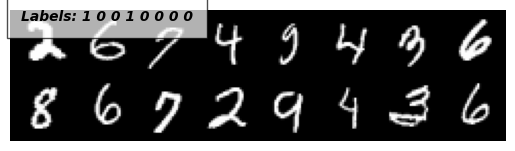

Labels: [1. 0. 0. 1. 0. 0. 0. 0.]


In [127]:
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# create a DataLoader
vis_dataloader = DataLoader(siamese_train_dataset,
                            shuffle=True,
                            batch_size=8)

# get a batch
img0_batch, img1_batch, label_batch = next(iter(vis_dataloader))

# concatenate pairs vertically for visualization
concatenated = torch.cat([torchvision.utils.make_grid(img0_batch),
                          torchvision.utils.make_grid(img1_batch)], dim=1)

# Show the batch with labels
imshow(concatenated, text="Labels: " + " ".join(str(int(l.item())) for l in label_batch))
print("Labels:", label_batch.numpy().reshape(-1))

# building the actual model

In [128]:
import torch
import torch.nn as nn


class SiameseNetwork(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 11 * 11, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),  # Final embedding size
        )

    def forward_once(self, x):
        output = self.cnn(x)
        # print(output.shape)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [129]:
net = SiameseNetwork(input_shape=1, hidden_units=10, output_shape=10)
img0, img1, label = next(iter(vis_dataloader))
img0, img1 = net(img0, img1)

# building the contrastive loss funciton

In [130]:
import torch.nn.functional as F


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # print(f"output1: {output1}, output2: {output2}, label: {label}")
        # Euclidean distance
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive


# prepare for training

In [131]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(siamese_train_dataset, shuffle=True, batch_size=32)
test_dataloader = DataLoader(siamese_test_dataset, shuffle=False, batch_size=32)

net = SiameseNetwork(input_shape=1, hidden_units=10, output_shape=len(siamese_train_dataset.label_to_indices.keys()))
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

# TRAINING LOOP

## try to load model first

In [132]:
from pathlib import Path
import torch

# Create the models directory if it doesn't exist
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "MNIST_siamese_network.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Try loading the model if it exists
if MODEL_SAVE_PATH.exists():
    loaded_net = SiameseNetwork(
        input_shape=1,
        hidden_units=10,
        output_shape=len(siamese_train_dataset.label_to_indices.keys())
    )
    loaded_net.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Model loaded from disk.")
else:
    loaded_net = None
    print("Model file not found. Will proceed to training.")


Model file not found. Will proceed to training.


## train (if no model was loaded)

In [ ]:
from tqdm.auto import tqdm

# Training loop with tqdm progress bar
num_epochs = 20
if not loaded_net:  # if we don't have a saved model
    print(f"No model loaded, beginning training...")
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch (Train): {epoch + 1}/{num_epochs}")

        for img0, img1, label in progress_bar:
            net.train()
            # forward pass
            output1, output2 = net(img0, img1)
            # calculate loss
            loss = criterion(output1, output2, label)
            # zero the optimizer
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # step the optimizer
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (progress_bar.n + 1)
            progress_bar.set_postfix(avg_loss=f"{avg_loss:.4f}")

    running_test_loss = 0.0
    progress_bar_test = tqdm(test_dataloader, desc=f"Epoch (Test): {epoch + 1}/{num_epochs}", colour="gray")
    for img0, img1, label in progress_bar_test:
        net.eval()
        output1, output2 = net(img0, img1)
        test_loss = criterion(output1, output2, label)
        running_test_loss += test_loss.item()
        avg_test_loss = running_test_loss / (progress_bar_test.n + 1)
        progress_bar_test.set_postfix(avg_test_loss=f"{avg_test_loss:.4f}")

else:
    print(f"Loaded model found, skipping training...")

No model loaded, beginning training...


Epoch (Train): 1/20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch (Train): 2/20:   0%|          | 0/313 [00:00<?, ?it/s]

## saving the model

In [120]:
# # Only save if we didn't load a pre-existing model
# if loaded_net is None:
#     print(f"Saving model to {MODEL_SAVE_PATH}")
#     torch.save(obj=net.state_dict(), f=MODEL_SAVE_PATH)
# else:
#     print("Model already loaded. Skipping save.")

# eval visualization

Making predictions using trained model (net)


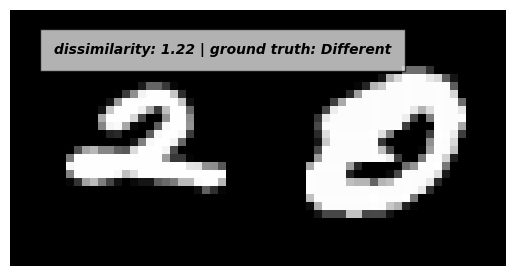

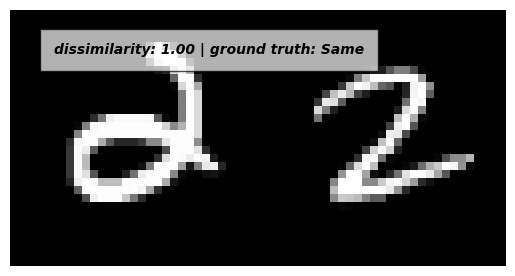

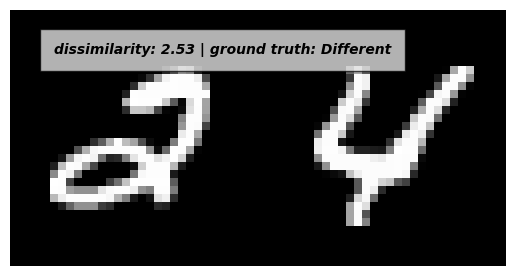

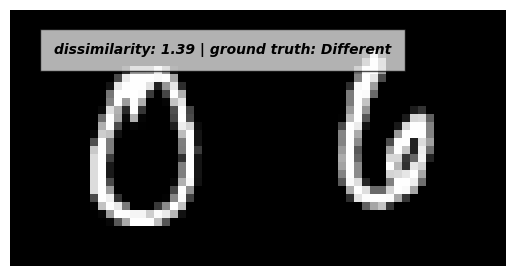

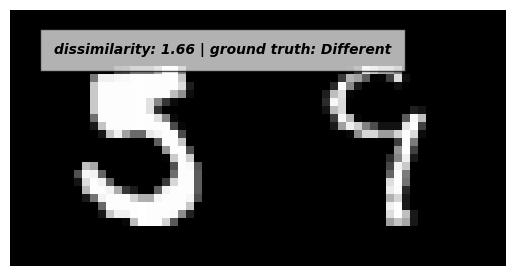

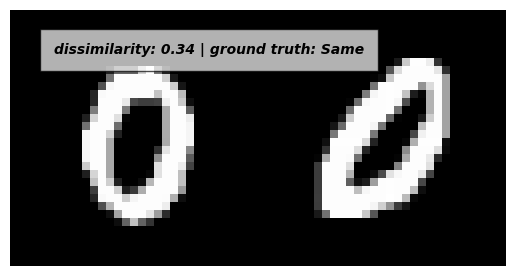

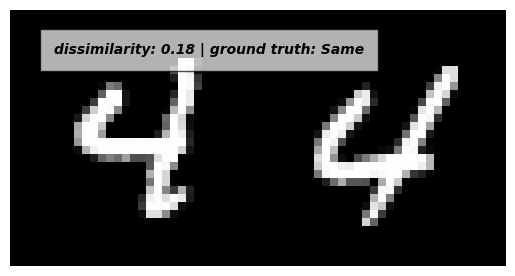

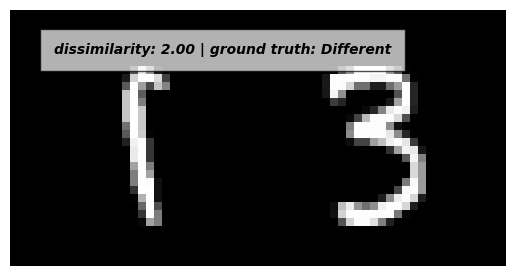

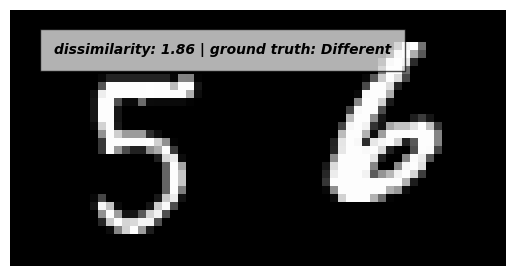

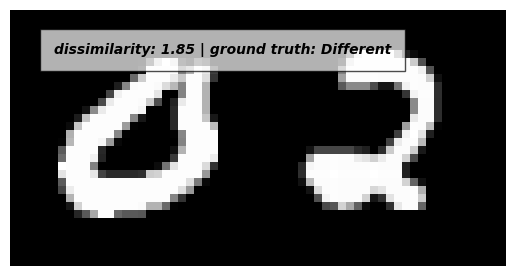

In [122]:
# Define transform and dataset
mnist = MNIST(root='./data', train=False, download=True)
siamese_test_dataset = SiameseNetworkDataset(mnist, transform)

if loaded_net is not None:
    print(f"Making predictions using loaded model (loaded_net)")
    evaluate_siamese_model(loaded_net, siamese_test_dataset)
else:
    print(f"Making predictions using trained model (net)")
    evaluate_siamese_model(net, siamese_test_dataset)